# MAIA Demo

#### Many of MAIA's experiments are available in the [experiment browser](https://multimodal-interpretability.csail.mit.edu/maia/experiment-browser/) ####

In [8]:
import os

import openai
from dotenv import load_dotenv

# Some imports require api key to be set ######
# Load environment variables
load_dotenv()

# Load OpenAI API key
openai.api_key = os.getenv("OPENAI_API_KEY")
openai.organization = os.getenv("OPENAI_ORGANIZATION")
###############################################


from maia_api import System, Tools, SyntheticSystem
from utils.DatasetExemplars import DatasetExemplars, SyntheticExemplars
from utils.main_utils import generate_save_path, create_bias_prompt, retrieve_synth_label
from utils.InterpAgent import InterpAgent
from utils.api_utils import str2image
from utils.ExperimentEnvironment import ExperimentEnvironment
from utils.call_agent import ask_agent
from IPython.display import clear_output


Stable-Diffusion 3.5 requires access to run. You can request it here: https://huggingface.co/stabilityai/stable-diffusion-3.5-medium

In [ ]:
# Login for access to sd-3.5
from huggingface_hub import login
login()

### Utils

In [9]:
# Plot the results from the experiment log
def plot_results_notebook(log_entry):
    if (log_entry['role'] == 'assistant'):
        print('\n\n*** MAIA: ***\n\n')  
    for item in log_entry['content']:
        if item['type'] == 'text':
            print(item['text'])
        elif item['type'] == 'image_url':
            display(str2image(item['image_url']['url'].split(',')[1]))

In [10]:
# MAIA's experiment loop, redefined here to display to the notebook after each step

class InterpAgentDemo(InterpAgent):
    def run_experiment(self, system: System, tools: Tools, save_html=False):
        """Runs the experiment loop. """

        # Make sure experiment log is clean
        self._init_experiment_log()
        experiment_env = ExperimentEnvironment(system, tools, globals())
        # Set Tools to point to this CodeAgent
        temp_agent, tools.agent = tools.agent, self
        # Experiment loop
        round_count = 0
        while True:
            round_count += 1
            model_experiment = ask_agent(self.model_name, self.experiment_log)
            self.update_experiment_log(role='model', type="text", type_content=str(model_experiment))
            # Plot the results from the experiment log
            clear_output()
            for log_entry in self.experiment_log:
                plot_results_notebook(log_entry)
            if save_html:
                tools.generate_html(self.experiment_log)
            if self.debug:
                print(model_experiment)
            
            if round_count > self.max_round_count:
                self._overload_instructions()
            else:
                if self.end_experiment_token in model_experiment:
                    break
                
                try:
                    experiment_output = experiment_env.execute_experiment(model_experiment)
                    if experiment_output != "":
                        self.update_experiment_log(role='user', type="text", type_content=experiment_output)
                except ValueError:
                    self.update_experiment_log(role='execution', 
                                               type="text", 
                                               type_content=f"No code to run was provided, please continue with the experiments based on your findings, or output your final {self.end_experiment_token}.")
        if save_html:
                tools.generate_html(self.experiment_log)
        
        # Restore tools to its original state
        tools.agent = temp_agent

### Arguments

In [19]:
maia_model = 'gpt-4o'
task = 'neuron_description'
n_exemplars = 15
model_name = "resnet152"
layer = "layer4"
neuron_num = 20
images_per_prompt = 1
path2save = '../results'
path2prompts = './prompts'
path2exemplars = './exemplars'
path2indices = './neuron_indices'
device = 0
text2image = 'sd'
debug = False

unit_config = {model_name: {layer: [neuron_num]}}

path2save = generate_save_path(path2save, maia_model, "test")
print(path2save)
os.makedirs(path2save, exist_ok=True)

../results/gpt-4o/test


### Initialize MAIA

In [20]:
# Prompt needs to be created dynamically for bias_discovery so class label can be inserted
if task == "bias_discovery":
    create_bias_prompt(path2indices, path2prompts, str(neuron_num))

# Add API configuration [(class, [methods])]
api = [
    (System, [System.call_neuron]),
    (Tools, [Tools.text2image, Tools.edit_images, Tools.dataset_exemplars, 
             Tools.display, Tools.describe_images, Tools.summarize_images])
]
try:
    del system
    del tools
except NameError:
    pass
maia = InterpAgentDemo(
    model_name=maia_model,
    api=api,
    prompt_path=path2prompts,
    api_prompt_name="api.txt",
    user_prompt_name=f"user_{task}.txt",
    overload_prompt_name="final.txt",
    end_experiment_token="[DESCRIPTION]",
    max_round_count=15,
    debug=debug
)
if model_name == "synthetic":
    net_dissect = SyntheticExemplars(
        os.path.join(path2exemplars, model_name),
        path2save,
        layer
    )
    gt_label = retrieve_synth_label(layer, neuron_num)
    system = SyntheticSystem(neuron_num, gt_label, layer, device)
else:
    net_dissect = DatasetExemplars(
        path2exemplars,
        n_exemplars,
        path2save,
        unit_config
    )
    system = System(model_name, layer, neuron_num, net_dissect.thresholds, device)

tools = Tools(
    path2save,
    device,
    maia,
    system,
    net_dissect,
    images_per_prompt=images_per_prompt,
    text2image_model_name=text2image,
    image2text_model_name=maia_model
)

print("HTML path: ", tools.html_path)

Loading pipeline components...:   0%|          | 0/9 [00:00<?, ?it/s]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

Loading pipeline components...:   0%|          | 0/6 [00:00<?, ?it/s]

HTML path:  ../results/gpt-4o/test/experiment_3.html


## Maia's api and user prompts

In [21]:
plot_results_notebook(maia.experiment_log[0])
plot_results_notebook(maia.experiment_log[1])

Class System:
    A Python class containing the vision model and the specific neuron to interact with.
    
    Attributes
    ----------
    neuron_num : int
        The unit number of the neuron.
    layer : string
        The name of the layer where the neuron is located.
    model_name : string
        The name of the vision model.
    model : nn.Module
        The loaded PyTorch model.
    
    Methods
    -------
    call_neuron(image_list: List[torch.Tensor]) -> Tuple[List[int], List[str]]
        Returns the neuron activation for each image in the input image_list as well as the original image (encoded into a Base64 string).

    def call_neuron(self, image_list: List[torch.Tensor]) -> Tuple[List[float], List[str]]:
        The function returns the neuron's maximum activation value (in int format) for each of the images in the list as well as the original image (encoded into a Base64 string).
        
        Parameters
        ----------
        image_list : List[torch.Tensor]

## Experiment

Class System:
    A Python class containing the vision model and the specific neuron to interact with.
    
    Attributes
    ----------
    neuron_num : int
        The unit number of the neuron.
    layer : string
        The name of the layer where the neuron is located.
    model_name : string
        The name of the vision model.
    model : nn.Module
        The loaded PyTorch model.
    
    Methods
    -------
    call_neuron(image_list: List[torch.Tensor]) -> Tuple[List[int], List[str]]
        Returns the neuron activation for each image in the input image_list as well as the original image (encoded into a Base64 string).

    def call_neuron(self, image_list: List[torch.Tensor]) -> Tuple[List[float], List[str]]:
        The function returns the neuron's maximum activation value (in int format) for each of the images in the list as well as the original image (encoded into a Base64 string).
        
        Parameters
        ----------
        image_list : List[torch.Tensor]

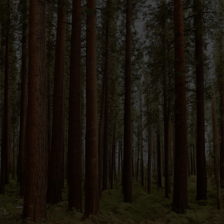

Activation: 1.0105900764465332


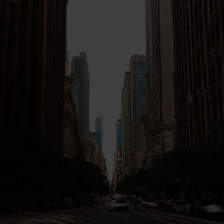

Activation: 1.312254548072815


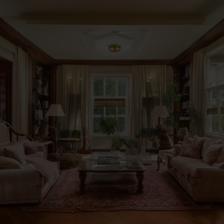

Activation: 0.8531584739685059


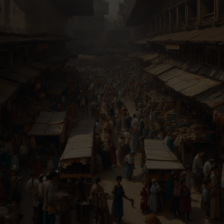

Activation: 0.9318664073944092


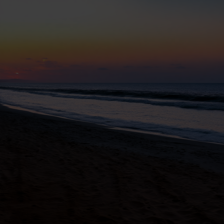

Activation: 1.1936179399490356


*** MAIA: ***


Based on the initial results, the neuron showed the highest activation for the city street scene with tall buildings, followed by the beach at sunset. The indoor room had the lowest activation.

**[HYPOTHESIS LIST]:**
- Hypothesis_1: The neuron is selective for urban environments or man-made structures.
- Hypothesis_2: The neuron is activated by vertical structures or tall elements in a scene.
- Hypothesis_3: The neuron responds to open spaces with wide vistas or clear horizons.

Let's test these hypotheses by creating more specific prompts focusing on architectural elements, vertical structures, and open spaces.

[CODE]:

```python
# Create specific prompts to test the initial hypotheses
detailed_prompt_list = [
    "skyscrapers in a modern cityscape",
    "a long road with a clear horizon",
    "mountain range with tall peaks",
    "a room with high ceilings and large windows",
    "a lighthouse by the sea"
]

# Generate images for the

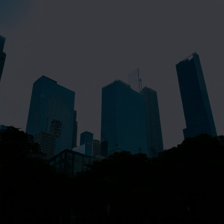

Activation: 1.7934932708740234


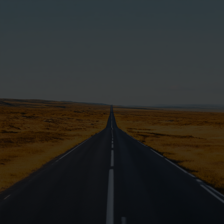

Activation: 0.595047116279602


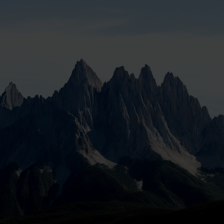

Activation: 0.5183680653572083


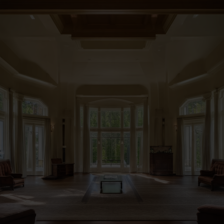

Activation: 0.44119977951049805


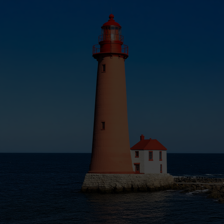

Activation: 1.8983938694000244


*** MAIA: ***


From the latest results, the neuron has a high activation for skyscrapers and lighthouses, indicating a preference for tall vertical structures in man-made environments. Other scenes, like open roads, mountain peaks, and high-ceiling rooms, resulted in lower activations.

**[HYPOTHESIS LIST]:**
- Hypothesis_1: The neuron is highly selective for tall, vertical structures, particularly those that are man-made.
- Hypothesis_2: The neuron is responsive to architectural features in urban settings.
- Hypothesis_3: Natural elements like mountains or open roads do not activate the neuron strongly, suggesting a focus on constructed environments.

To further test these hypotheses, let's examine the neuron's response to various architectural styles and structures with distinct vertical characteristics.

[CODE]:

```python
# Further exploration with a focus on different architectural styles and structures
additional_prompt_list = [
    "an ancient s

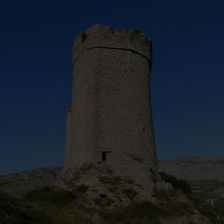

Activation: 0.4710720181465149


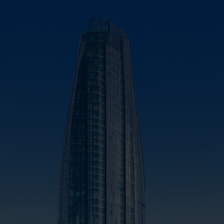

Activation: 1.2460780143737793


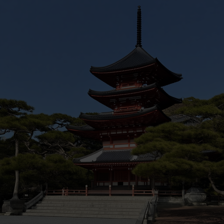

Activation: 1.0947809219360352


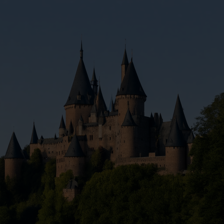

Activation: 1.8730814456939697


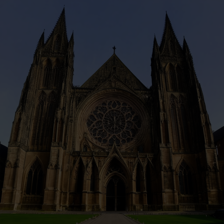

Activation: 0.16016405820846558


*** MAIA: ***


The latest results continue to support the hypothesis that the neuron is highly selective for tall and vertical man-made structures, particularly those with distinctive architectural features. The highest activations were observed for the medieval castle and modern skyscraper, while the Gothic cathedral had the lowest activation.

**[HYPOTHESIS LIST]:**
- Hypothesis_1: The neuron is selective for tall vertical structures with intricate or distinctive architectural designs.
- Hypothesis_2: The neuron has a strong response to structures like castles and skyscrapers, possibly due to their prominent verticality and grandeur.
- Hypothesis_3: The neuron prefers constructed environments over natural or less distinctive architectural features.

With strong evidence supporting these hypotheses, let's finalize our conclusions about the neuron selectivity.

[DESCRIPTION]: The neuron is selective for tall, distinctive man-made structures such as ca

In [22]:
# Run full experiment
maia.run_experiment(system, tools, save_html=True)

### Manual Experiment
To manually run experiment steps, run this cell repeatedly. 

In [32]:
# To reset maia's experiment log to just the api and user prompt, run
maia._init_experiment_log()
experiment_env = ExperimentEnvironment(system, tools, globals())

In [33]:
model_experiment = ask_agent(maia.model_name, maia.experiment_log)
experiment_output = experiment_env.execute_experiment(model_experiment)
maia.update_experiment_log(role='user', type="text", type_content=experiment_output)
# Plot the results from the experiment log
for log_entry in maia.experiment_log:
    plot_results_notebook(log_entry)

'Class System:\n    A Python class containing the vision model and the specific neuron to interact with.\n    \n    Attributes\n    ----------\n    neuron_num : int\n        The unit number of the neuron.\n    layer : string\n        The name of the layer where the neuron is located.\n    model_name : string\n        The name of the vision model.\n    model : nn.Module\n        The loaded PyTorch model.\n    \n    Methods\n    -------\n    call_neuron(image_list: List[torch.Tensor]) -> Tuple[List[int], List[str]]\n        Returns the neuron activation for each image in the input image_list as well as the original image (encoded into a Base64 string).\n\n    def call_neuron(self, image_list: List[torch.Tensor]) -> Tuple[List[float], List[str]]:\n        The function returns the neuron\'s maximum activation value (in int format) for each of the images in the list as well as the original image (encoded into a Base64 string).\n        \n        Parameters\n        ----------\n        image

'Your overall task is to describe the visual concepts that maximally activate a\nneuron inside a deep network for computer vision. \n\nTo do that you are provided with a library of Python functions to run\nexperiments on each unit (inside the "System" class) given the functions\nprovided in the "Tools" class. Do not initialize these classes, they are already\navailable for you to use (names are \'system\' and \'tools\' respectively).  Make\nsure to use a variety of tools from the library to maximize your experimentation\npower. At each experiment step, write Python code that will\nconduct your experiment on the model, using the following format:\n[CODE]:\n\n```python\n# write Python code using your knowledge of Python and the System and Tools\n# class for running experiments. You must display values if you want\n# to see them. They will not be displayed automatically.\n```\nInclude only a single instance of experiment implementation at each step. Your\ncode will be executed. Wait for t

''